In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# TP3

El objetivo de este trabajo práctico es intentar predecir si una persona es pobre o no utilizando distintas variables de características individuales que limpiaron y los distintos clasificadores vistos en clase. Recuerden que en los trabajos prácticos anteriores crearon dos bases de datos distintas: `respondieron`, que tiene datos de personas que sí respondieron su ingreso (ITF) y `norespondieron`, que tienen aquellas personas que no declaran su ingreso.

In [2]:
df = pd.read_csv("data/datos_filtrados.csv")

# # Creamos las bases según el ITF
respondieron = df[df['ITF'] > 0].copy()
norespondieron = df[df['ITF'] == 0].copy()

In [6]:
respondieron.head()

,edad,edad2,educ,ingreso_total_familiar,num_miembros_hogar,horastrab,pobre,AÑO,ITF
0,80.0,6400.0,10.0,1.038173e+06,1,NaN,0,2005,583
1,26.0,676.0,13.0,8.013344e+05,3,NaN,0,2005,450
2,27.0,729.0,16.0,8.013344e+05,3,NaN,0,2005,450
3,NaN,NaN,NaN,8.013344e+05,3,NaN,0,2005,450
4,71.0,5041.0,8.0,1.522535e+06,1,NaN,0,2005,855


# A. Enfoque de validación 
Utilicen la base respondieron. Para cada año, dividan las observaciones en una base de prueba (test) y una de entrenamiento (train) utilizando el comando train_test_split. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (random state instance) debe ser 444. Establezca a pobre como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables seleccionadas serán las variables independientes (matriz X). Recuerden agregar la columna de unos (1) para el intercepto. Aclaración: no incluir la variable ingreso en X para predecir la pobreza porque cuando vayamos a la base de norespondieron no vamos a tener esa información. 

In [7]:
from sklearn.model_selection import train_test_split


# Variables 
feature_cols = ["edad", "edad2", "educ", "horastrab", "num_miembros_hogar"]
target_col = "pobre"

# Diccionarios para guardar resultados por año
X_train_by_year = {}
X_test_by_year = {}
y_train_by_year = {}
y_test_by_year = {}

for año in sorted(respondieron["AÑO"].dropna().unique()):
    df_year = respondieron[respondieron["AÑO"] == año].copy()
    # Quitamos observaciones sin target o sin las features requeridas
    cols_needed = [target_col] + feature_cols
    df_year = df_year.dropna(subset=cols_needed)
    n = df_year.shape[0]
    if n == 0:
        print(f"Año {año}: 0 observaciones tras eliminar NA. Se omite.")
        continue

    X = df_year[feature_cols].astype(float)
    y = df_year[target_col].astype(int)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, train_size=0.7, test_size=0.3, random_state=444
    )

    # Agregar columna de unos para intercepto
    X_tr = X_tr.copy()
    X_te = X_te.copy()
    X_tr["const"] = 1
    X_te["const"] = 1

    # Guardar en diccionarios
    X_train_by_year[año] = X_tr
    X_test_by_year[año] = X_te
    y_train_by_year[año] = y_tr
    y_test_by_year[año] = y_te

    print(f"Año {año}: total={n:,} | train={X_tr.shape[0]:,} | test={X_te.shape[0]:,}")



Año 2005: total=1,013 | train=709 | test=304
Año 2025: total=814 | train=569 | test=245


## 1.	 Cree una tabla de diferencia de medias entre la base de entrenamiento y la de testeo de las características seleccionadas en su matriz X. Para la matriz de las X seleccione variables que hayan limpiado en los TPs anteriores y justifique su inclusión para predecir la pobreza. Comente la tabla de la diferencia de medias de sus variables entre entrenamiento y testeo. ¿Hay diferencias significativas entre las medias del entrenamiento y testeo? 

In [8]:
from scipy import stats
import pandas as pd
import numpy as np

# variables usadas en X 
feature_cols = ["edad", "edad2", "educ", "horastrab", "num_miembros_hogar"]

rows = []
for año in sorted(X_train_by_year.keys()):
    X_tr = X_train_by_year[año]
    X_te = X_test_by_year[año]
    for col in feature_cols:
        if col not in X_tr.columns or col not in X_te.columns:
            continue
        a = X_tr[col].dropna().astype(float)
        b = X_te[col].dropna().astype(float)
        if len(a) < 2 or len(b) < 2:
            continue
        m_tr, sd_tr, n_tr = a.mean(), a.std(ddof=1), a.size
        m_te, sd_te, n_te = b.mean(), b.std(ddof=1), b.size
        diff = m_tr - m_te
        
        # Welch t-test 
        tstat, pval = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
        signif = pval < 0.05
        rows.append({
            "AÑO": año,
            "variable": col,
            "mean_train": m_tr,
            "sd_train": sd_tr,
            "n_train": n_tr,
            "mean_test": m_te,
            "sd_test": sd_te,
            "n_test": n_te,
            "diff (train - test)": diff,
            "t_stat": tstat,
            "p_value": pval,
            "signif_p<0.05": signif
        })

tabla_diff = pd.DataFrame(rows)
#  más legible
tabla_diff = tabla_diff[["AÑO","variable","n_train","mean_train","sd_train","n_test","mean_test","sd_test","diff (train - test)","t_stat","p_value","signif_p<0.05"]]

#  resultados 
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
print("Tabla de diferencia de medias (train vs test) por año y variable:")
display(tabla_diff.reset_index(drop=True))



Tabla de diferencia de medias (train vs test) por año y variable:


,AÑO,variable,n_train,mean_train,sd_train,n_test,mean_test,sd_test,diff (train - test),t_stat,p_value,signif_p<0.05
0,2005,edad,709,36.963,13.014,304,37.115,13.505,-0.152,-0.166,0.868,False
1,2005,edad2,709,1535.423,1120.621,304,1559.326,1204.507,-23.903,-0.295,0.768,False
2,2005,educ,709,10.831,3.806,304,10.688,3.666,0.143,0.563,0.573,False
3,2005,horastrab,709,33.797,85.439,304,30.875,61.435,2.922,0.613,0.540,False
4,2005,num_miembros_hogar,709,4.188,1.977,304,4.214,1.936,-0.026,-0.196,0.844,False
5,2025,edad,569,41.698,13.230,245,42.343,13.006,-0.645,-0.646,0.519,False
6,2025,edad2,569,1913.417,1263.617,245,1961.396,1220.248,-47.979,-0.509,0.611,False
7,2025,educ,569,13.257,3.740,245,13.078,3.985,0.179,0.599,0.550,False
8,2025,horastrab,569,26.185,23.988,245,30.416,66.261,-4.232,-0.973,0.332,False
9,2025,num_miembros_hogar,569,3.494,1.344,245,3.527,1.430,-0.033,-0.304,0.761,False


Observando la tabla de resultados anterior, ninguna fila tiene `signif_p<0.05 = True`, por lo que con un test de Welch no hay diferencias estadísticamente significativas entre las medias de train y test para las variables listadas (edad, edad2, educ, horastrab, num_miembros_hogar) en 2005 ni en 2025. Esto es bueno ya que quiere decir que tienen distribuciones similares y que modelo no iria a generalizar

## 2.	Separen la base respondieron en dos: respondieron_2005 y respondieron_2025. Idem con la base norespondieron. 

In [10]:
respondieron_2025 = respondieron[respondieron['AÑO'] == 2025].copy()
respondieron_2005 = respondieron[respondieron['AÑO'] == 2005].copy()

In [12]:
norespondieron_2025 = norespondieron[norespondieron['AÑO'] == 2025].copy()
norespondieron_2005 = norespondieron[norespondieron['AÑO'] == 2005].copy()

# B. Modelo de Regresion Logística



## 3.	Estimación y Efectos Marginales: Estimen una Regresión Logística usando X_train de respondieron_2025. Exporten una tabla con: (i) los coeficientes estimados para cada variable, (ii) los errores estándar y (ii) los odd-ratios. Interpreten los resultados de la tabla. (Hint: en la clase 7 hay una ilustración de la tabla).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


year = 2025
if year not in X_train_by_year:
    raise KeyError(f"Año {year} no está en X_train_by_year. Claves disponibles: {sorted(X_train_by_year.keys())}")

# Datos
X_tr = X_train_by_year[year].copy()
X_te = X_test_by_year[year].copy()
y_tr = y_train_by_year[year].astype(int).copy()
y_te = y_test_by_year[year].astype(int).copy()

# quitar columna de const (scikit-learn ajusta intercepto por defecto)
X_tr = X_tr.drop(columns=["const"], errors="ignore")
X_te = X_te.drop(columns=["const"], errors="ignore")

# asegurar tipo numérico
X_tr = X_tr.astype(float)
X_te = X_te.astype(float)

# Ajustar LogisticRegression sin regularización y si falla  L2 con C grande
try:
    clf = LogisticRegression(penalty='none', solver='lbfgs', max_iter=2000)
    clf.fit(X_tr, y_tr)
except Exception:
    clf = LogisticRegression(penalty='l2', C=1e6, solver='lbfgs', max_iter=2000)
    clf.fit(X_tr, y_tr)

# errores estándar aproximados 


p_train = clf.predict_proba(X_tr)[:, 1]
W = p_train * (1 - p_train)
X_design = np.hstack([np.ones((X_tr.shape[0], 1)), X_tr.values])  # intercepto + predictores
XTWX = X_design.T @ (W[:, None] * X_design)
# usar pseudo-inversa por seguridad
cov_beta = np.linalg.pinv(XTWX)
se_beta = np.sqrt(np.diag(cov_beta))

# preparar índices y coeficientes (intercept + coeficientes)
idx = ["intercept"] + list(X_tr.columns)
coef_all = np.concatenate([clf.intercept_, clf.coef_.ravel()])
odds_all = np.exp(coef_all)

# Construir dataframe de resultados con errores estándar
res_df = pd.DataFrame({
    "coef": coef_all,
    "std_err": se_beta,
    "odds_ratio": odds_all
}, index=idx)

# Predicciones y métricas en test
y_score_te = clf.predict_proba(X_te)[:, 1]
y_pred_te = clf.predict(X_te)
auc = roc_auc_score(y_te, y_score_te)
report = classification_report(y_te, y_pred_te, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Guardar resultados
res_df.to_csv(f"results_logit_sklearn_coef_odds_se_{year}.csv")
report_df.to_csv(f"results_logit_sklearn_classif_report_{year}.csv")



# Mostrar resumen
pd.set_option("display.float_format", lambda x: f"{x:.4f}")
print(f"Regresión logística scikit-learn — entrenamiento {year}")
display(res_df)
print(f"\nAUC (test): {auc:.4f}")
display(report_df)


Regresión logística scikit-learn — entrenamiento 2025


,coef,std_err,odds_ratio
intercept,0.0048,1.1083,1.0049
edad,0.0842,0.0519,1.0878
edad2,-0.0013,0.0006,0.9987
educ,-0.2376,0.0357,0.7885
horastrab,-0.0179,0.0046,0.9823
num_miembros_hogar,0.4180,0.0832,1.5189



AUC (test): 0.7930


,precision,recall,f1-score,support
0,0.7739,0.9167,0.8392,168.0000
1,0.6957,0.4156,0.5203,77.0000
accuracy,0.7592,0.7592,0.7592,0.7592
macro avg,0.7348,0.6661,0.6798,245.0000
weighted avg,0.7493,0.7592,0.7390,245.0000


In [23]:
from scipy.stats import norm


# Recalcular elementos si no existen en el scope
if 'coef_all' not in globals() or 'se_beta' not in globals():
    p_train = clf.predict_proba(X_tr)[:, 1]
    W = p_train * (1 - p_train)
    X_design = np.hstack([np.ones((X_tr.shape[0], 1)), X_tr.values])
    XTWX = X_design.T @ (W[:, None] * X_design)
    cov_beta = np.linalg.pinv(XTWX)
    se_beta = np.sqrt(np.diag(cov_beta))
    coef_all = np.concatenate([clf.intercept_, clf.coef_.ravel()])
    idx = ["intercept"] + list(X_tr.columns)
else:
    idx = ["intercept"] + list(X_tr.columns)

# Estadísticos z, p-valores e intervalos de confianza para coeficientes
z = coef_all / se_beta
pvals = 2 * (1 - norm.cdf(np.abs(z)))
ci_low = coef_all - norm.ppf(0.975) * se_beta
ci_high = coef_all + norm.ppf(0.975) * se_beta

# Odds ratios e IC
odds_ratio = np.exp(coef_all)
odds_ci_low = np.exp(ci_low)
odds_ci_high = np.exp(ci_high)

# Efectos marginales promedio (AME) 
p_train = clf.predict_proba(X_tr)[:, 1]
m = np.mean(p_train * (1 - p_train))
beta = coef_all[1:]  # sin intercept
ame = m * beta
# SE aproximada para AME vía delta method: se_AME ≈ |m| * se(beta_j)
se_ame = np.abs(m) * se_beta[1:]
z_ame = ame / se_ame
pval_ame = 2 * (1 - norm.cdf(np.abs(z_ame)))


results = pd.DataFrame({
    "coef": coef_all,
    "std_err": se_beta,
    "z": z,
    "p_value": pvals,
    "ci_low": ci_low,
    "ci_high": ci_high,
    "odds_ratio": odds_ratio,
    "odds_ci_low": odds_ci_low,
    "odds_ci_high": odds_ci_high
}, index=idx)

ame_df = pd.DataFrame({
    "AME": np.concatenate([[np.nan], ame]),
    "AME_std_err": np.concatenate([[np.nan], se_ame]),
    "AME_z": np.concatenate([[np.nan], z_ame]),
    "AME_p_value": np.concatenate([[np.nan], pval_ame])
}, index=idx)

final_results = pd.concat([results, ame_df], axis=1)

pd.set_option("display.float_format", lambda x: f"{x:.4f}")
display(final_results)

# Guardar
final_results.to_csv(f"results_logit_sklearn_full_results_{year}.csv")

# Resumen rápido
sig_vars = final_results[final_results["p_value"] < 0.05].index.tolist()
print("Variables (coef) con p < 0.05:", sig_vars if sig_vars else "ninguna")
sig_ame = final_results[final_results["AME_p_value"] < 0.05].index.tolist()
print("Variables (AME) con p < 0.05:", sig_ame if sig_ame else "ninguna")

,coef,std_err,z,p_value,ci_low,ci_high,odds_ratio,odds_ci_low,odds_ci_high,AME,AME_std_err,AME_z,AME_p_value
intercept,0.0048,1.1083,0.0044,0.9965,-2.1674,2.1771,1.0049,0.1145,8.8205,NaN,NaN,NaN,NaN
edad,0.0842,0.0519,1.6220,0.1048,-0.0175,0.1859,1.0878,0.9826,1.2043,0.0136,0.0084,1.6220,0.1048
edad2,-0.0013,0.0006,-2.2678,0.0233,-0.0025,-0.0002,0.9987,0.9975,0.9998,-0.0002,0.0001,-2.2678,0.0233
educ,-0.2376,0.0357,-6.6641,0.0000,-0.3075,-0.1678,0.7885,0.7353,0.8456,-0.0383,0.0057,-6.6641,0.0000
horastrab,-0.0179,0.0046,-3.9125,0.0001,-0.0268,-0.0089,0.9823,0.9736,0.9911,-0.0029,0.0007,-3.9125,0.0001
num_miembros_hogar,0.4180,0.0832,5.0216,0.0000,0.2549,0.5812,1.5189,1.2903,1.7881,0.0673,0.0134,5.0216,0.0000


Variables (coef) con p < 0.05: ['edad2', 'educ', 'horastrab', 'num_miembros_hogar']
Variables (AME) con p < 0.05: ['edad2', 'educ', 'horastrab', 'num_miembros_hogar']



variables significativas: edad2, educ, horastrab, num_miembros_hogar.
variables no significativas: intercept, edad (p ≈ 0.105).


Para educación:
coef = −0.2376, OR = 0.7885 (IC 0.735–0.846), p << 0.001.
Interpretación: cada año adicional de educación reduce las probabilidades de ser pobre en ≈21.2%. y segun el AME: −0.0383 habria una reducción de 3.8 puntos porcentuales en la probabilidad de pobreza por año de educación (promedio).

Miembros del hogar (num_miembros_hogar):
coef = 0.4180, OR = 1.5189 (IC 1.290–1.788), p << 0.001.
Interpretación: cada miembro adicional aumenta las odds de pobreza 51.9%. segun el AME 6.7 puntos porcentuales más de probabilidad por miembro adicional (promedio).


Horas trabajadas (horastrab):
coef = −0.0179, OR = 0.9823 (IC 0.974–0.991), p ≈ 0.0001.
Interpretación: cada hora trabajada reduce las odds ≈1.77%; el AME indica aprox 0.29 puntos porcentuales menos en la probabilidad por hora trabajada.


Edad (edad y edad2):
edad coef = +0.0842 (no significativo a 5%), edad2 coef = −0.0013 (significativo).
Interpretación: relación no lineal: la probabilidad de pobreza aumenta con la edad hasta un máximo y luego disminuye. Punto máximo aproximado = −β_edad / (2·β_edad2) ≈ 0.0842 / (2·0.0013) ≈ 32.4 años.
AME reportado para edad ≈ +0.0136 (≈1.36 p.p.) y para edad2 ≈ −0.0002 .

Intervalos y confianza:
Los IC de los OR muestran que los efectos de educ y num_miembros_hogar son robustos (no cruzan 1). Horastrab también consistente.
Intercept con alta incertidumbre

## 	4. Visualización: Grafiquen la P ̂(Y=1|X) (en el eje vertical) y alguna característica numérica (en el eje horizontal). Comente dicho gráfico y la variable seleccionada para ilustrar la probabilidad de ser pobre según la característica seleccionada. (Hint: en la clase 7 hay una ilustración de este estilo).

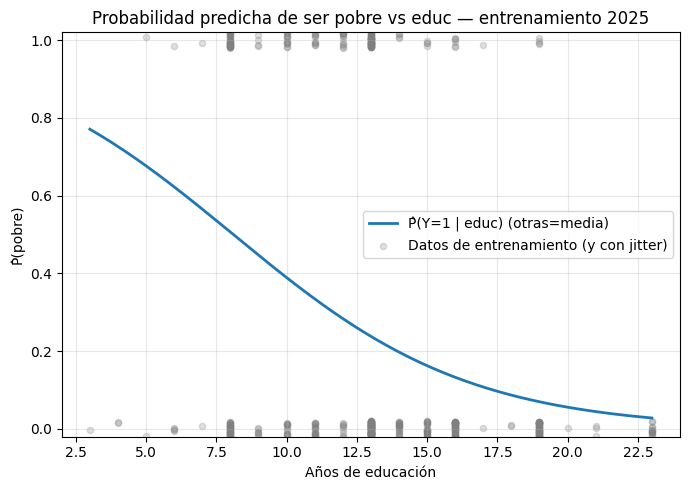

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

feature = "educ"
# rango para la variable elegida
grid = np.linspace(X_tr[feature].min(), X_tr[feature].max(), 200)


X_grid = pd.DataFrame({col: np.repeat(X_tr[col].mean(), grid.size) for col in X_tr.columns})
X_grid[feature] = grid


if "edad" in X_tr.columns and "edad2" in X_tr.columns:
    pass

# predecir probabilidades
p_grid = clf.predict_proba(X_grid)[:, 1]

#  figura
plt.figure(figsize=(7, 5))
sns.lineplot(x=grid, y=p_grid, color="tab:blue", lw=2, label="P̂(Y=1 | " + feature + ") (otras=media)")
#  puntos de entrenamiento 
y_jitter = y_tr.values + np.random.uniform(-0.02, 0.02, size=len(y_tr))
plt.scatter(X_tr[feature], y_jitter, alpha=0.25, s=20, color="gray", label="Datos de entrenamiento (y con jitter)")

plt.xlabel("Años de educación")
plt.ylabel("P̂(pobre)")
plt.ylim(-0.02, 1.02)
plt.title(f"Probabilidad predicha de ser pobre vs {feature} — entrenamiento {year}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()